# Loan Default Prediction with Keras — Case Study on `loan_data.csv`

## 1) Scenario
A digital lending platform wants to pre-screen applications for **default risk** at origination. Each application includes basic financial attributes (income, debt, credit history) and a categorical **loan purpose**. The lender aims to reduce delinquency and optimize pricing/limits by identifying high-risk loans early, while maintaining fair access to credit.

## 2) Problem Statement
Build a binary classifier to predict **`loan_status`** (1 = good/paid as agreed, 0 = default/bad) at the time of loan approval using application-time features.  
Key objectives:
- High **recall** on bad loans (catch more risky cases),
- Balanced with acceptable **precision** to avoid rejecting too many good borrowers,
- Provide a simple, production-ready Keras model and preprocessing pipeline.

## 3) Data Description (columns in `loan_data.csv`)
- **credit_policy** *(int)* — Whether applicant meets internal underwriting policy (indicator or score).
- **loan_purpose** *(categorical)* — Purpose of the loan (e.g., Debt Payment, Education, Household, Business, Travel, Vehicle).
- **interest_rate** *(float)* — Quoted nominal interest rate at origination.
- **installment_amount** *(float)* — Monthly EMI.
- **log_annual_income** *(float)* — Natural log of self-reported annual income.
- **debt_to_income_ratio** *(float)* — DTI at application time.
- **fico_score** *(int)* — FICO score.
- **days_with_credit_line** *(float)* — Age of oldest credit line in days.
- **revolving_balance** *(float)* — Current revolving balance.
- **revolving_utilization** *(float)* — Utilization percentage of revolving credit.
- **inquiries_last_6_months** *(int)* — Recent hard inquiries.
- **delinquencies_last_2_years** *(int)* — 30+ day delinquencies in last 2 years.
- **public_records** *(int)* — Public derogatory records (e.g., bankruptcies).
- **loan_status** *(binary target)* — **1** = good, **0** = bad (default/delinquent).

> **Confidentiality Note:** Some features may be **masked and scaled** for privacy; treat them as standardized numeric signals during modeling.

---

We will:
1. Build a solid **data pipeline** (imputation, encoding, scaling).
2. Train a **logistic regression baseline** (single Dense + sigmoid).
3. Upgrade to an **MLP** (nonlinear FFNN) with regularization and early stopping.
4. Run **experiments**: mini-batch vs pattern vs batch, early stopping, initializers, optimizers, depth/width sweeps.
5. Produce **reproducible metrics & plots** to decide a default configuration.


Notes:
- Some fields may have **missing values**; we’ll impute (`median` for numeric, `most_frequent` for categorical).
- Distributions are typically skewed (e.g., balances, utilizations). Standardization helps SGD.

---

## 2) Setup & Imports


In [1]:
# If needed:
# !pip install -U tensorflow scikit-learn matplotlib numpy pandas
import os, math, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, Tuple

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, classification_report
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

DATA_PATH = "loan_data.csv"  # ensure the CSV is available in the working directory
assert Path(DATA_PATH).exists(), f"File not found: {DATA_PATH}"

ImportError: cannot import name 'keras' from 'tensorflow' (unknown location)

## 3) Load, Clean, Split

In [12]:
# Read CSV
df = pd.read_csv(DATA_PATH)



# Basic sanity: expected columns
expected = [
    "credit_policy","loan_purpose","interest_rate","installment_amount","log_annual_income",
    "debt_to_income_ratio","fico_score","days_with_credit_line","revolving_balance",
    "revolving_utilization","inquiries_last_6_months","delinquencies_last_2_years",
    "public_records","loan_status"
]
missing_cols = set(expected) - set(df.columns)
if missing_cols:
    raise ValueError(f"Missing columns in CSV: {missing_cols}")

# Coerce dtypes
df["loan_purpose"] = df["loan_purpose"].astype("category")
for col in ["credit_policy","inquiries_last_6_months","delinquencies_last_2_years","public_records","loan_status"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Quick peek
display(df.head(10))
print(df.isna().mean().sort_values(ascending=False).head(10))
print("Class balance:", df["loan_status"].value_counts(normalize=True).to_dict())

# Create dummy variables
df = pd.get_dummies(data=df,dtype=int,drop_first=True)

# Train/val/test split (stratified)
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["loan_status"], random_state=42
)
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df["loan_status"], random_state=42
)

y_train = train_df["loan_status"].values.astype(int)
y_val   = val_df["loan_status"].values.astype(int)
y_test  = test_df["loan_status"].values.astype(int)


,credit_policy,loan_purpose,interest_rate,installment_amount,log_annual_income,debt_to_income_ratio,fico_score,days_with_credit_line,revolving_balance,revolving_utilization,inquiries_last_6_months,delinquencies_last_2_years,public_records,loan_status
0,1,Debt Payment,0.1008,162.34,11.350407,NaN,712.0,2699.958333,33667,73.2,1,0,0,0
1,1,Education,0.1426,102.92,11.299732,14.97,667.0,4066.000000,4740,39.5,0,1,0,0
2,1,Education,0.0788,125.13,11.904968,16.98,727.0,6120.041667,50807,51.0,0,0,0,0
3,1,Debt Payment,0.1496,194.02,10.714418,4.00,667.0,3180.041667,3839,76.8,0,0,1,1
4,1,Household,0.1114,131.22,11.002100,NaN,722.0,5116.000000,24220,68.6,0,0,0,1
5,1,Business,0.1134,87.19,11.407565,17.25,682.0,3989.000000,69909,51.1,1,0,0,0
6,1,Debt Payment,0.1221,84.12,10.203592,10.00,707.0,2730.041667,5630,23.0,1,0,0,0
7,1,Debt Payment,0.1347,360.43,10.434116,22.09,677.0,6713.041667,13846,71.0,2,0,1,0
8,1,Debt Payment,0.1324,253.58,11.835009,NaN,662.0,4298.000000,5122,18.2,2,1,0,0
9,1,Debt Payment,0.0859,316.11,10.933107,15.49,767.0,6519.958333,6068,16.7,0,0,0,0


debt_to_income_ratio     0.005871
loan_purpose             0.002609
days_with_credit_line    0.001957
fico_score               0.000326
credit_policy            0.000000
interest_rate            0.000000
installment_amount       0.000000
log_annual_income        0.000000
revolving_balance        0.000000
revolving_utilization    0.000000
dtype: float64
Class balance: {0: 0.5, 1: 0.5}


In [15]:
df.columns

Index(['credit_policy', 'interest_rate', 'installment_amount',
       'log_annual_income', 'debt_to_income_ratio', 'fico_score',
       'days_with_credit_line', 'revolving_balance', 'revolving_utilization',
       'inquiries_last_6_months', 'delinquencies_last_2_years',
       'public_records', 'loan_status', 'loan_purpose_Business',
       'loan_purpose_Debt Payment', 'loan_purpose_Education',
       'loan_purpose_Household', 'loan_purpose_Travel',
       'loan_purpose_Vehicle'],
      dtype='object')

## 4) Preprocessing Pipeline (Impute → Encode → Scale)

In [16]:
NUM_FEATS = ['interest_rate','installment_amount','log_annual_income',
             'debt_to_income_ratio','fico_score','days_with_credit_line',
             'revolving_balance','revolving_utilization']
CAT_FEATS = ['loan_purpose_Business',
       'loan_purpose_Debt Payment', 'loan_purpose_Education',
       'loan_purpose_Household', 'loan_purpose_Travel',
       'loan_purpose_Vehicle']
BIN_FEATS = ['credit_policy','inquiries_last_6_months',
             'delinquencies_last_2_years','public_records']

X = df[NUM_FEATS + CAT_FEATS + BIN_FEATS]
y = df['loan_status']

# Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocessing
numeric_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transform, NUM_FEATS),
    ('cat', categorical_transform, CAT_FEATS)
], remainder='passthrough')

X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

input_dim = X_train_prep.shape[1]


## 5) Utilities: Plots & Evaluation

In [17]:
def plot_history(h, title="History"):
    plt.figure()
    if "loss" in h.history: plt.plot(h.history["loss"], label="loss")
    if "val_loss" in h.history: plt.plot(h.history["val_loss"], label="val_loss")
    if "auc" in h.history: plt.plot(h.history["auc"], label="auc")
    if "val_auc" in h.history: plt.plot(h.history["val_auc"], label="val_auc")
    if "accuracy" in h.history: plt.plot(h.history["accuracy"], label="acc")
    if "val_accuracy" in h.history: plt.plot(h.history["val_accuracy"], label="val_acc")
    plt.title(title); plt.xlabel("Epoch"); plt.legend(); plt.show()

def evaluate_model(model, X, y, name="Model"):
    y_prob = model.predict(X, verbose=0).ravel()
    y_hat = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y, y_hat)
    auc = roc_auc_score(y, y_prob)
    print(f"{name} → ACC: {acc:.3f} | AUC: {auc:.3f}")
    print(confusion_matrix(y, y_hat))
    print(classification_report(y, y_hat, digits=3))
    return {"acc": acc, "auc": auc}


In [24]:
X_train_prep.shape

(2146, 24)

In [25]:
y_train.shape

(2146,)

## 6) Baseline: Logistic Regression (Keras)

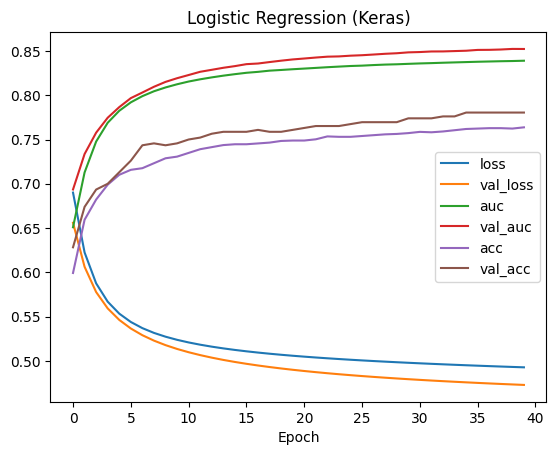

Validation:
LR/Val → ACC: 0.780 | AUC: 0.852
[[204  42]
 [ 59 155]]
              precision    recall  f1-score   support

           0      0.776     0.829     0.802       246
           1      0.787     0.724     0.754       214

    accuracy                          0.780       460
   macro avg      0.781     0.777     0.778       460
weighted avg      0.781     0.780     0.780       460

Test:
LR/Test → ACC: 0.748 | AUC: 0.827
[[174  51]
 [ 65 170]]
              precision    recall  f1-score   support

           0      0.728     0.773     0.750       225
           1      0.769     0.723     0.746       235

    accuracy                          0.748       460
   macro avg      0.749     0.748     0.748       460
weighted avg      0.749     0.748     0.748       460



In [27]:
def build_lr(input_dim, initializer="glorot_uniform"):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(1, activation="sigmoid", kernel_initializer=initializer)
    ])
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=0.05),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
    return model

lr_model = build_lr(X_train_prep.shape[1])
hist_lr = lr_model.fit(
    X_train_prep, y_train,
    validation_data=(X_val_prep, y_val),
    epochs=40, batch_size=128, verbose=0
)
plot_history(hist_lr, "Logistic Regression (Keras)")
print("Validation:"); _ = evaluate_model(lr_model, X_val_prep, y_val, "LR/Val")
print("Test:");       _ = evaluate_model(lr_model, X_test_prep, y_test, "LR/Test")


## 7) FFNN (MLP) with Regularization + Early Stopping

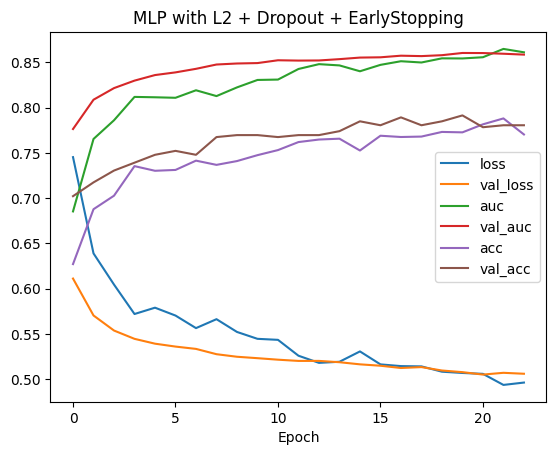

Validation:
MLP/Val → ACC: 0.791 | AUC: 0.860
[[203  43]
 [ 53 161]]
              precision    recall  f1-score   support

           0      0.793     0.825     0.809       246
           1      0.789     0.752     0.770       214

    accuracy                          0.791       460
   macro avg      0.791     0.789     0.790       460
weighted avg      0.791     0.791     0.791       460

Test:
MLP/Test → ACC: 0.780 | AUC: 0.853
[[179  46]
 [ 55 180]]
              precision    recall  f1-score   support

           0      0.765     0.796     0.780       225
           1      0.796     0.766     0.781       235

    accuracy                          0.780       460
   macro avg      0.781     0.781     0.780       460
weighted avg      0.781     0.780     0.780       460



In [31]:
def build_mlp(input_dim, width=128, depth=2, act="relu",
              l2=1e-4, dropout=0.2, initializer="he_uniform", lr=1e-3, opt="adam"):
    layers_list = [layers.Input(shape=(input_dim,))]
    for _ in range(depth):
        layers_list.append(
            layers.Dense(width, activation=act,
                         kernel_regularizer=regularizers.l2(l2),
                         kernel_initializer=initializer)
        )
        if dropout and dropout > 0:
            layers_list.append(layers.Dropout(dropout))
    layers_list.append(layers.Dense(1, activation="sigmoid"))
    model = keras.Sequential(layers_list)

    if opt == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif opt == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=lr)

    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics=["accuracy", keras.metrics.AUC(name="auc")])
    return model

es = keras.callbacks.EarlyStopping(monitor="val_auc", mode="max",
                                   patience=3, restore_best_weights=True)

mlp = build_mlp(X_train_prep.shape[1], width=128, depth=2, dropout=0.2, l2=1e-4,
                initializer="he_uniform", lr=1e-3, opt="adam")
hist_mlp = mlp.fit(
    X_train_prep, y_train,
    validation_data=(X_val_prep, y_val),
    epochs=30, batch_size=128, verbose=0,
    callbacks=[es]
)
plot_history(hist_mlp, "MLP with L2 + Dropout + EarlyStopping")
print("Validation:"); _ = evaluate_model(mlp, X_val_prep, y_val, "MLP/Val")
print("Test:");       _ = evaluate_model(mlp, X_test_prep, y_test, "MLP/Test")


## 8) Experiments

### 8.1 Modes of Learning (Pattern vs Batch vs Mini-batch)

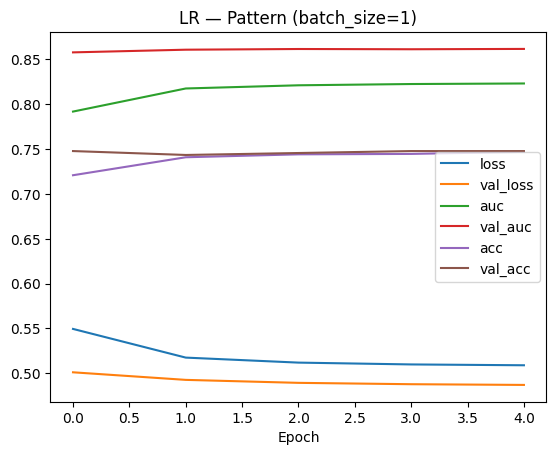

Pattern (batch_size=1) Val:
Pattern (batch_size=1)/Val → ACC: 0.748 | AUC: 0.862
[[238   8]
 [108 106]]
              precision    recall  f1-score   support

           0      0.688     0.967     0.804       246
           1      0.930     0.495     0.646       214

    accuracy                          0.748       460
   macro avg      0.809     0.731     0.725       460
weighted avg      0.800     0.748     0.731       460



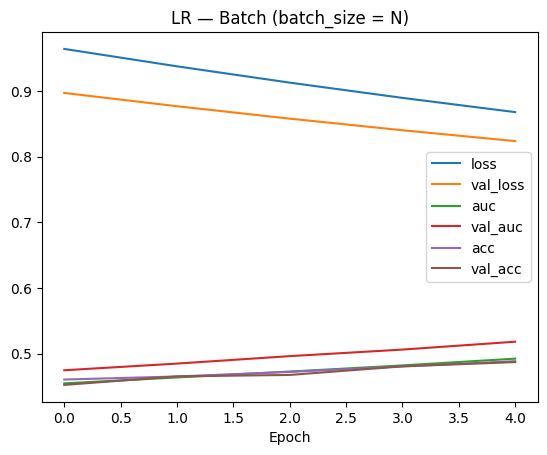

Batch (batch_size = N) Val:
Batch (batch_size = N)/Val → ACC: 0.487 | AUC: 0.518
[[ 85 161]
 [ 75 139]]
              precision    recall  f1-score   support

           0      0.531     0.346     0.419       246
           1      0.463     0.650     0.541       214

    accuracy                          0.487       460
   macro avg      0.497     0.498     0.480       460
weighted avg      0.500     0.487     0.476       460



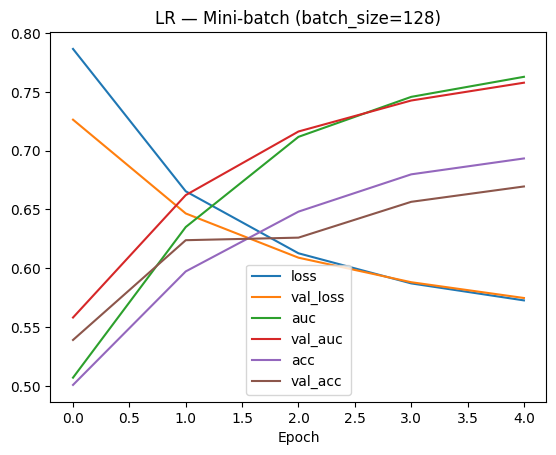

Mini-batch (batch_size=128) Val:
Mini-batch (batch_size=128)/Val → ACC: 0.670 | AUC: 0.758
[[175  71]
 [ 81 133]]
              precision    recall  f1-score   support

           0      0.684     0.711     0.697       246
           1      0.652     0.621     0.636       214

    accuracy                          0.670       460
   macro avg      0.668     0.666     0.667       460
weighted avg      0.669     0.670     0.669       460



In [35]:
def train_with_batch_size(batch_size, title):
    model = build_lr(X_train_prep.shape[1])  # use simple LR to isolate mode effect
    h = model.fit(
        X_train_prep, y_train, validation_data=(X_val_prep, y_val),
        epochs=5, batch_size=batch_size, verbose=0
    )
    plot_history(h, f"LR — {title}")
    print(title, "Val:"); _ = evaluate_model(model, X_val_prep, y_val, title + "/Val")
    return model

_ = train_with_batch_size(1, "Pattern (batch_size=1)")
_ = train_with_batch_size(len(X_train_prep), "Batch (batch_size = N)")
_ = train_with_batch_size(128, "Mini-batch (batch_size=128)")


### 8.2 Stopping Criteria (Fixed vs Early Stopping)

Fixed epochs — Val:
Fixed/Val → ACC: 0.774 | AUC: 0.864
[[207  39]
 [ 65 149]]
              precision    recall  f1-score   support

           0      0.761     0.841     0.799       246
           1      0.793     0.696     0.741       214

    accuracy                          0.774       460
   macro avg      0.777     0.769     0.770       460
weighted avg      0.776     0.774     0.772       460

Early stopping — Val:
EarlyStop/Val → ACC: 0.785 | AUC: 0.866
[[203  43]
 [ 56 158]]
              precision    recall  f1-score   support

           0      0.784     0.825     0.804       246
           1      0.786     0.738     0.761       214

    accuracy                          0.785       460
   macro avg      0.785     0.782     0.783       460
weighted avg      0.785     0.785     0.784       460



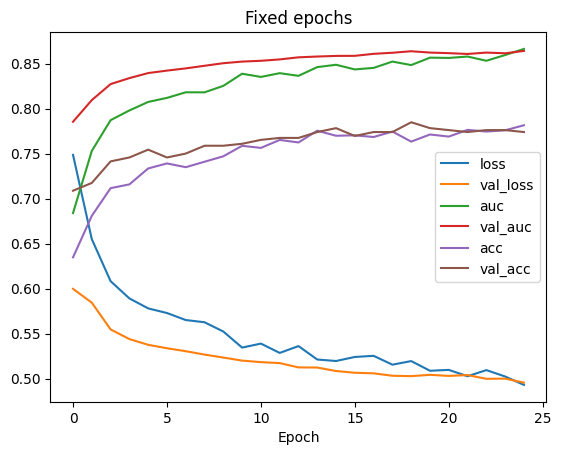

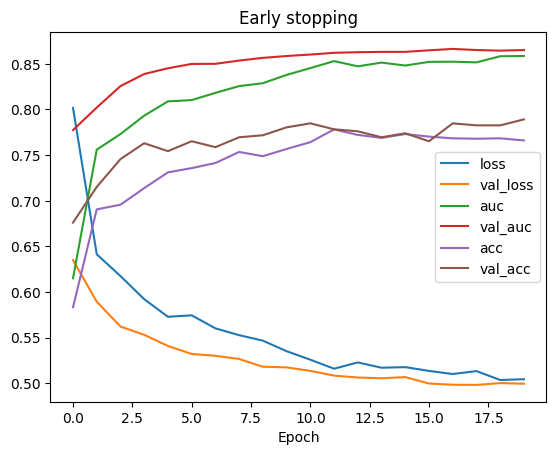

In [39]:
# Fixed epochs
fixed_mlp = build_mlp(X_train_prep.shape[1], width=128, depth=2, lr=1e-3, opt="adam")
h_fixed = fixed_mlp.fit(
    X_train_prep, y_train, validation_data=(X_val_prep, y_val),
    epochs=25, batch_size=128, verbose=0
)
print("Fixed epochs — Val:"); _ = evaluate_model(fixed_mlp, X_val_prep, y_val, "Fixed/Val")

# Early stopping
es = keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True)
es_mlp = build_mlp(X_train_prep.shape[1], width=128, depth=2, lr=1e-3, opt="adam")
h_es = es_mlp.fit(
    X_train_prep, y_train, validation_data=(X_val_prep, y_val),
    epochs=50, batch_size=128, verbose=0, callbacks=[es]
)
print("Early stopping — Val:"); _ = evaluate_model(es_mlp, X_val_prep, y_val, "EarlyStop/Val")

plot_history(h_fixed, "Fixed epochs")
plot_history(h_es, "Early stopping")


### 8.4 Optimizer Bake-off

In [40]:
opts = {
    "sgd":  keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    "adam": keras.optimizers.Adam(learning_rate=1e-3),
    "rmsprop": keras.optimizers.RMSprop(learning_rate=1e-3),
}
results_opt = {}
for name, opt in opts.items():
    m = build_mlp(X_train_prep.shape[1], initializer="he_uniform", lr=1e-3, opt="adam")  # opt inside compile anyway
    m.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy", keras.metrics.AUC(name="auc")])
    m.fit(X_train_prep, y_train, validation_data=(X_val_prep, y_val),
          epochs=12, batch_size=128, verbose=0)
    metrics = evaluate_model(m, X_val_prep, y_val, f"Opt={name}/Val")
    results_opt[name] = metrics
results_opt


Opt=sgd/Val → ACC: 0.774 | AUC: 0.863
[[212  34]
 [ 70 144]]
              precision    recall  f1-score   support

           0      0.752     0.862     0.803       246
           1      0.809     0.673     0.735       214

    accuracy                          0.774       460
   macro avg      0.780     0.767     0.769       460
weighted avg      0.778     0.774     0.771       460

Opt=adam/Val → ACC: 0.763 | AUC: 0.854
[[206  40]
 [ 69 145]]
              precision    recall  f1-score   support

           0      0.749     0.837     0.791       246
           1      0.784     0.678     0.727       214

    accuracy                          0.763       460
   macro avg      0.766     0.757     0.759       460
weighted avg      0.765     0.763     0.761       460

Opt=rmsprop/Val → ACC: 0.765 | AUC: 0.848
[[206  40]
 [ 68 146]]
              precision    recall  f1-score   support

           0      0.752     0.837     0.792       246
           1      0.785     0.682     0.730      

{'sgd': {'acc': 0.7739130434782608, 'auc': 0.863137299597295},
 'adam': {'acc': 0.7630434782608696, 'auc': 0.853544563483018},
 'rmsprop': {'acc': 0.7652173913043478, 'auc': 0.8483018007750172}}

### 8.5 Capacity (Depth/Width) Sweep

In [43]:
grid = [(1,64), (1,128), (2,128), (2,256), (3,256)]
cap_results = []
for depth, width in grid:
    m = build_mlp(X_train_prep.shape[1], depth=depth, width=width, lr=1e-3, opt="adam")
    m.fit(X_train_prep, y_train, validation_data=(X_val_prep, y_val),
          epochs=15, batch_size=128, verbose=0)
    metrics = evaluate_model(m, X_val_prep, y_val, f"Depth={depth},Width={width}/Val")
    cap_results.append({"depth": depth, "width": width, **metrics})
pd.DataFrame(cap_results).sort_values("auc", ascending=False)


Depth=1,Width=64/Val → ACC: 0.763 | AUC: 0.841
[[192  54]
 [ 55 159]]
              precision    recall  f1-score   support

           0      0.777     0.780     0.779       246
           1      0.746     0.743     0.745       214

    accuracy                          0.763       460
   macro avg      0.762     0.762     0.762       460
weighted avg      0.763     0.763     0.763       460

Depth=1,Width=128/Val → ACC: 0.776 | AUC: 0.854
[[201  45]
 [ 58 156]]
              precision    recall  f1-score   support

           0      0.776     0.817     0.796       246
           1      0.776     0.729     0.752       214

    accuracy                          0.776       460
   macro avg      0.776     0.773     0.774       460
weighted avg      0.776     0.776     0.775       460

Depth=2,Width=128/Val → ACC: 0.789 | AUC: 0.861
[[206  40]
 [ 57 157]]
              precision    recall  f1-score   support

           0      0.783     0.837     0.809       246
           1      0.797  

,depth,width,acc,auc
4,3,256,0.793478,0.869026
2,2,128,0.789130,0.861029
3,2,256,0.763043,0.857420
1,1,128,0.776087,0.854209
0,1,64,0.763043,0.841121


## 9) Pick a Final Model & Test

In [45]:
# Example: choose the best from capacity sweep or optimizer bake-off (manually or programmatically).
# Here, we retrain a "good" config with early stopping and evaluate on TEST.
final_m = build_mlp(X_train_prep.shape[1], depth=2, width=256, lr=1e-3, opt="adam",
                    initializer="he_uniform", dropout=0.2, l2=1e-4)
es = keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=4, restore_best_weights=True)
final_m.fit(X_train_prep, y_train, validation_data=(X_val_prep, y_val),
            epochs=40, batch_size=128, verbose=0, callbacks=[es])

print("FINAL — Val:"); _ = evaluate_model(final_m, X_val_prep, y_val, "Final/Val")
print("FINAL — Test:"); _ = evaluate_model(final_m, X_test_prep, y_test, "Final/Test")


FINAL — Val:
Final/Val → ACC: 0.783 | AUC: 0.865
[[212  34]
 [ 66 148]]
              precision    recall  f1-score   support

           0      0.763     0.862     0.809       246
           1      0.813     0.692     0.747       214

    accuracy                          0.783       460
   macro avg      0.788     0.777     0.778       460
weighted avg      0.786     0.783     0.780       460

FINAL — Test:
Final/Test → ACC: 0.774 | AUC: 0.852
[[187  38]
 [ 66 169]]
              precision    recall  f1-score   support

           0      0.739     0.831     0.782       225
           1      0.816     0.719     0.765       235

    accuracy                          0.774       460
   macro avg      0.778     0.775     0.774       460
weighted avg      0.779     0.774     0.773       460

